<a href="https://colab.research.google.com/github/srhill12/waco-prophet-rnn-predictions/blob/main/Waco_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
from prophet import Prophet
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM




In [6]:
# Load and preprocess the data
data = pd.read_csv('/new_renamed_store3_data.csv')


In [7]:
data.head()

,Year,Week,Monthn,Sales,Gallons,date
0,2007,47,11,0.00,NaN,2007-11-19
1,2007,48,11,4697.64,148.0,2007-11-26
2,2007,49,12,3233.57,88.0,2007-12-03
3,2007,50,12,4526.86,133.0,2007-12-10
4,2007,51,12,7291.96,250.0,2007-12-17


In [8]:
data.tail()

,Year,Week,Monthn,Sales,Gallons,date
987,2024,18,5,15687.08,256.0,2024-04-29
988,2024,19,5,26200.68,492.0,2024-05-06
989,2024,20,5,24729.34,473.0,2024-05-13
990,2024,21,5,27596.85,571.0,2024-05-20
991,2024,22,5,18877.38,281.0,2024-05-27


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     992 non-null    int64  
 1   Week     992 non-null    int64  
 2   Monthn   992 non-null    int64  
 3   Sales    990 non-null    float64
 4   Gallons  989 non-null    float64
 5   date     992 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 46.6+ KB


In [10]:
# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

In [11]:
# Handle missing values
data['Sales'].fillna(data['Sales'].mean(), inplace=True)
data['Gallons'].fillna(data['Gallons'].mean(), inplace=True)

In [12]:
# Ensure no remaining missing values
print(data.isnull().sum())

Year       0
Week       0
Monthn     0
Sales      0
Gallons    0
date       0
dtype: int64


In [14]:
# Prepare data for Prophet
data = data[['date', 'Sales']].rename(columns={'date': 'ds', 'Sales': 'y'})

In [15]:
# Train the Prophet model
prophet_model = Prophet()
prophet_model.fit(data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeooi96z6/svgnwk46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeooi96z6/aexygo0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27155', 'data', 'file=/tmp/tmpeooi96z6/svgnwk46.json', 'init=/tmp/tmpeooi96z6/aexygo0k.json', 'output', 'file=/tmp/tmpeooi96z6/prophet_model__vwuyfm/prophet_model-20240704001520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:15:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
# Make future dataframe
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds         yhat   yhat_lower   yhat_upper
0 2007-11-19  4121.508149  -475.062866  8947.167871
1 2007-11-26  3885.310827  -772.530128  8438.736934
2 2007-12-03  4061.386259  -587.688868  8901.766453
3 2007-12-10  4204.326591  -513.576258  8906.401440
4 2007-12-17  3959.443161 -1028.972387  8878.027250


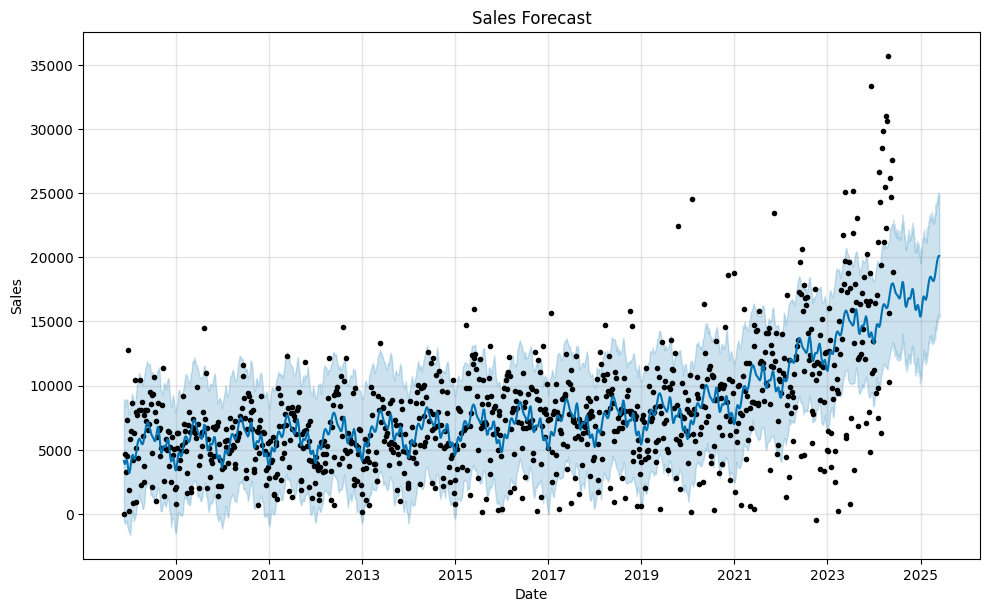

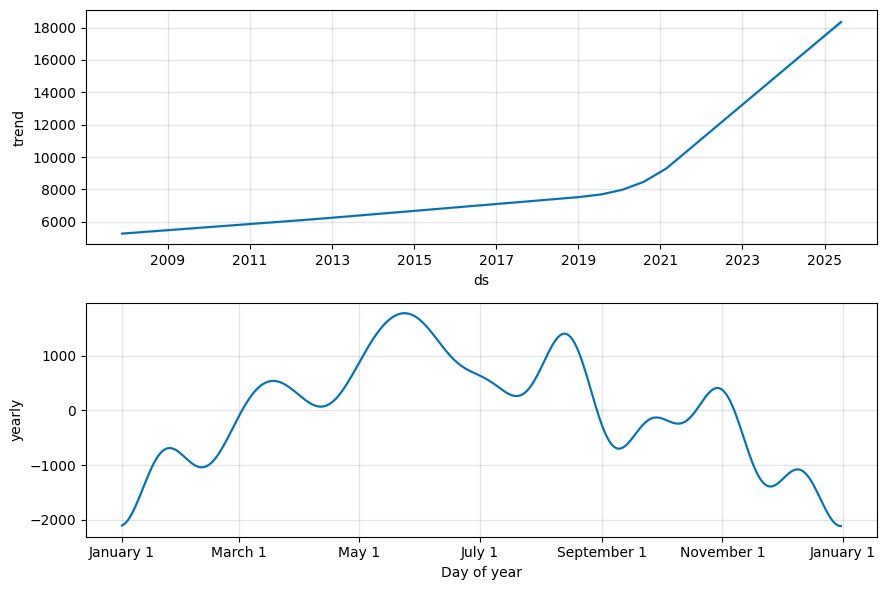

In [18]:
# Plot the forecast

import matplotlib.pyplot as plt

# Plot the forecast
fig1 = prophet_model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Plot the forecast components
fig2 = prophet_model.plot_components(forecast)
plt.show()


In [19]:
# Calculate residuals
data['residual'] = data['y'] - forecast['yhat']

In [20]:
# Check for NaN values in residuals
if data['residual'].isnull().sum() > 0:
    print("NaN values found in residuals. Filling NaN values with 0.")
    data['residual'].fillna(0, inplace=True)

In [21]:
# Prepare residuals for RNN
residuals = data['residual'].values
residuals = residuals.reshape(-1, 1)

In [22]:
# Normalize the residuals
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
residuals = scaler.fit_transform(residuals)

In [23]:
# Create sequences for RNN
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(residuals, seq_length)

In [24]:
# Split into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [25]:
# Build the RNN model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Train the RNN
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
25/25 [==============================] - 7s 52ms/step - loss: 0.0441 - val_loss: 0.0272
Epoch 2/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0095 - val_loss: 0.0243
Epoch 3/20
25/25 [==============================] - 0s 15ms/step - loss: 0.0076 - val_loss: 0.0245
Epoch 4/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 0.0246
Epoch 5/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 0.0244
Epoch 6/20
25/25 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0250
Epoch 7/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0076 - val_loss: 0.0245
Epoch 8/20
25/25 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0246
Epoch 9/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0076 - val_loss: 0.0248
Epoch 10/20
25/25 [==============================] - 0s 15ms/step - loss: 0.0076 - val_loss: 0.0243
Epoch 11/

In [28]:
# Predict residuals with RNN
rnn_predictions = model.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)

7/7 [==============================] - 1s 5ms/step


In [29]:
# Combine Prophet and RNN predictions
combined_forecast = forecast['yhat'][-len(rnn_predictions):].values + rnn_predictions.flatten()

In [31]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(data['y'][-len(rnn_predictions):], combined_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['y'][-len(rnn_predictions):], combined_forecast)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 31691104.40929687
RMSE: 5629.485270368586
MAE: 4299.108540486768


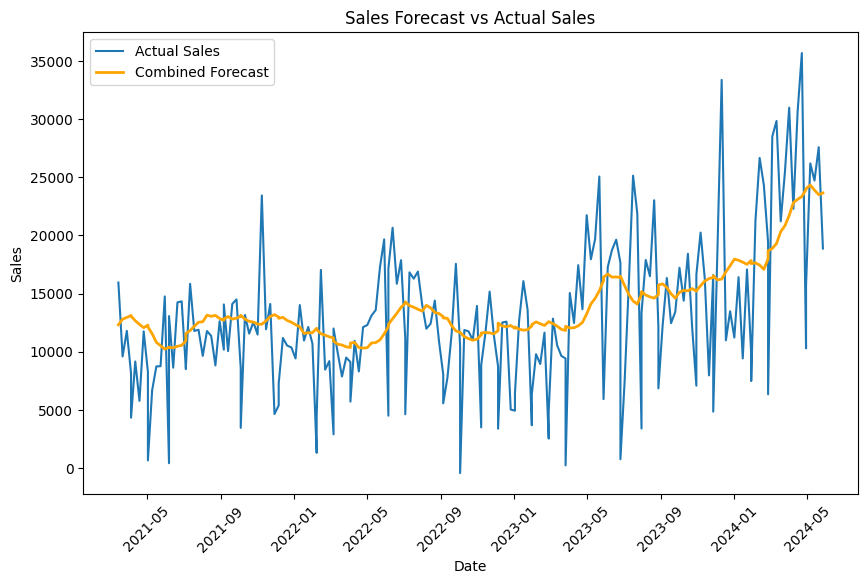

In [33]:
# Evaluate the combined forecast
plt.figure(figsize=(10, 6))  # Increase figure size
plt.plot(data['ds'][-len(rnn_predictions):], data['y'][-len(rnn_predictions):], label='Actual Sales')
plt.plot(data['ds'][-len(rnn_predictions):], combined_forecast, label='Combined Forecast', color='orange', linewidth=2)  # Use thicker line for combined forecast
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.title('Sales Forecast vs Actual Sales')
plt.show()